In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler #
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score, confusion_matrix, recall_score
#maybe delete recall_score

#not sure if this is allowed
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as imb_pipeline # to tune sampling methods

#temporary
from collections import Counter

from model import FraudDetector

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = pd.read_csv("historical.csv")
data.head()

,tid,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,outcome
0,49b18cea-beb8-413d-b268-a0ec12a4147c,1.423808,-0.377568,0.242070,-0.697073,-0.763104,-0.731960,-0.367360,-0.278617,-0.996840,...,-0.469381,-0.810630,0.034175,-0.063592,0.252775,0.975686,-0.047713,0.008093,10.00,0
1,0d1de000-6756-4441-8133-e0ed75b72979,0.386691,1.932803,-1.958157,1.795148,0.597989,-1.752021,0.567382,0.225227,-0.614899,...,-0.037188,0.066752,0.232243,0.269168,-0.566513,-0.403250,0.151074,-0.044239,3.99,0
2,dc548f8c-ecd2-4fee-8a80-f2de7e2c7bd6,-0.822247,1.349695,-2.533342,-1.510371,2.429420,3.097419,-0.337696,1.778629,-0.306968,...,-0.280728,-0.954416,0.226719,0.589009,-0.325611,0.173346,0.110327,-0.006745,14.55,0
3,f105abf5-0c4c-4e79-9a8a-59de254e58dc,-0.679009,0.452323,1.256676,-1.163474,-0.871992,-0.413326,-0.319045,0.414021,-1.479641,...,0.171611,0.365879,-0.164711,0.366073,0.089739,-0.314979,-0.185542,-0.032110,10.00,0
4,164a2881-40c6-43ba-b53e-cd1e5a9e8cee,1.174152,-0.493073,-0.136508,-1.375827,-0.506841,-0.760343,0.066490,-0.174785,1.165490,...,-0.061790,-0.016600,-0.226672,0.107551,0.738778,-0.010159,-0.008166,0.006128,68.54,0


# EDA

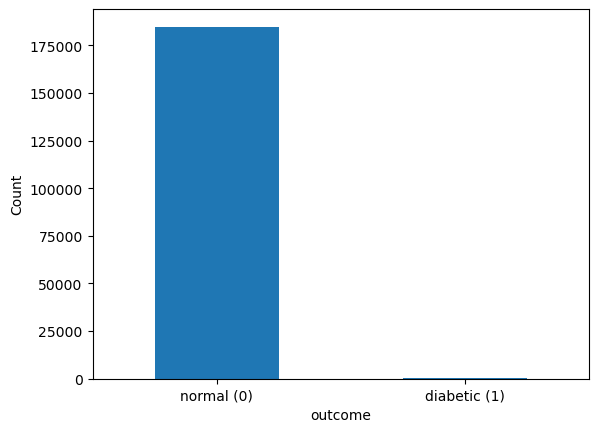

In [3]:
target = data["outcome"]
class_mapping = {0: "normal (0)", 1: "diabetic (1)"}
target.map(class_mapping).value_counts().plot.bar(rot=0)
plt.ylabel("Count")
plt.show()

<Axes: xlabel='V1', ylabel='V2'>

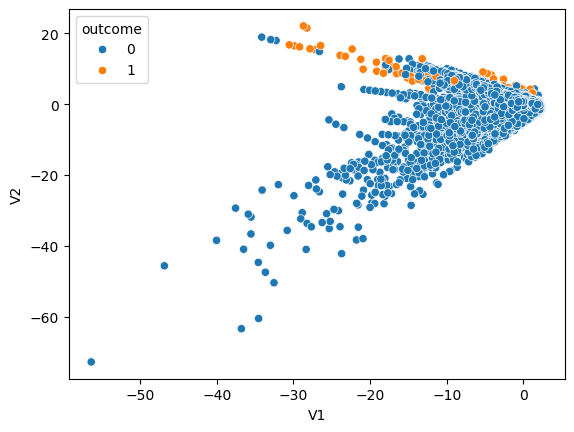

In [4]:
sns.scatterplot(x=data["V1"], y=data["V2"], hue=target)

In [5]:
target.value_counts()

outcome
0    184804
1       320
Name: count, dtype: int64

# Baseline: See results of Random Forest without balancing classes

In [6]:
# Separate features (PCA & Amount) from target
X, y = data.iloc[:, 1:-1], data.iloc[:, -1]

# 20% of entire data is the hold-out set
X_Train, X_test, y_Train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=target
)

# 20% of entire data is validation set while 60% is the train set
X_train, X_val, y_train, y_val = train_test_split(
    X_Train, y_Train, test_size=0.25, random_state=0, stratify=y_Train
)

# print out the training and validation set sizes
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

X_train shape: (111074, 29)
X_val shape: (37025, 29)


## Without scaler

In [7]:
rf_untuned = Pipeline(
    [("clf", FraudDetector())]
)

rf_untuned.fit(X_train, y_train)

# Measure performance on validation set

rf_untuned_train = rf_untuned.predict(X_train) # We have to measure train performance manually
rf_untuned_val = rf_untuned.predict(X_val)   

In [21]:
rf_untuned_val

array([0, 0, 0, ..., 0, 0, 0])

In [8]:
print("==========Untuned Random Forest==========")
print(f"Training F1 Score: {f1_score(y_train, rf_untuned_train):.4f}")

print("Validation Set performance:\n", classification_report(y_val, rf_untuned_val))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, rf_untuned_val)))

==========Untuned Random Forest==========
Training F1 Score: 1.0000
Validation Set performance:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     36961
           1       0.96      0.75      0.84        64

    accuracy                           1.00     37025
   macro avg       0.98      0.87      0.92     37025
weighted avg       1.00      1.00      1.00     37025

Validation Set Confusion Matrix:
        0   1
0  36959   2
1     16  48


In [20]:
#used to compute the bank specific rates
rf_untuned_results = confusion_matrix(y_val, rf_untuned_val)
print("Fraud Capture Rate?")
print(rf_untuned_results[1][1]/
      (rf_untuned_results[1][0]+rf_untuned_results[1][1]))

Fraud Capture Rate?
0.75


## With Scaler (I don't think this is needed for Random Forest, but just be safe)

- Update: no changes. so just remove this in final report

In [9]:
rf_scaled_untuned = Pipeline(
    [("scaler", StandardScaler()),
     ("clf", FraudDetector())]
)

rf_scaled_untuned.fit(X_train, y_train)

# Measure performance on validation set

rf_scaled_untuned_train = rf_scaled_untuned.predict(X_train) # We have to measure train performance manually
rf_scaled_untuned_val = rf_scaled_untuned.predict(X_val)   

KeyboardInterrupt: 

In [ ]:
print("==========Tuned Random Forest==========")
print(f"Training F1 Score: {f1_score(y_train, rf_scaled_untuned_train):.4f}")

print("Validation Set performance:\n", classification_report(y_val, rf_scaled_untuned_val))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, rf_scaled_untuned_val)))

In [ ]:
#used to compute the bank specific rates
rf_scaled_untuned_results = confusion_matrix(y_val, rf_scaled_untuned_val)
print("Fraud Capture Rate?")
print(rf_scaled_untuned_results[1][1]/
      (rf_scaled_untuned_results[1][0]+rf_scaled_untuned_results[1][1]))

## Tuning through Stratified KFold (temporary)
- so far, model.py does not allow tuning of random forest parameters... so focus on model imbalance for now

In [14]:
#[1e-5, 1e-3, 1e-2, 0.1, 0.2, 0.4, 0.75, 1, 1.5, 3, 5, 10, 20, 100] 
#[0.001, 0.01, 0.1, 1.0, 10, 100] 

In [15]:
"""rf_params = {
    'clf__n_estimators': [20, 50, 100],
    'clf__max_depth': [10, 20, 30, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__class_weight': [None, 'balanced', 'balanced_subsample'],
}"""

"rf_params = {\n    'clf__n_estimators': [20, 50, 100],\n    'clf__max_depth': [10, 20, 30, None],\n    'clf__min_samples_split': [2, 5, 10],\n    'clf__class_weight': [None, 'balanced', 'balanced_subsample'],\n}"

In [16]:
"""rf_tuning = Pipeline(
    [("clf", FraudDetector())]
)

# Stratify KFold to train model using train set
skf = StratifiedKFold(n_splits=5, random_state=39, shuffle=True)

smote_rcv = RandomizedSearchCV(rf_tuning, 
                         rf_params, 
                         random_state=39,
                         cv=skf)

search = smote_rcv.fit(X_train, y_train)

best_lr_params = search.best_params_
lr_tuned = search.best_estimator_

# Measure performance on validation set
lr_tuned_train = lr_tuned.predict(X_train)
lr_tuned_val = lr_tuned.predict(X_val) """

'rf_tuning = Pipeline(\n    [("clf", FraudDetector())]\n)\n\n# Stratify KFold to train model using train set\nskf = StratifiedKFold(n_splits=5, random_state=39, shuffle=True)\n\nsmote_rcv = RandomizedSearchCV(rf_tuning, \n                         rf_params, \n                         random_state=39,\n                         cv=skf)\n\nsearch = smote_rcv.fit(X_train, y_train)\n\nbest_lr_params = search.best_params_\nlr_tuned = search.best_estimator_\n\n# Measure performance on validation set\nlr_tuned_train = lr_tuned.predict(X_train)\nlr_tuned_val = lr_tuned.predict(X_val) '

In [18]:
"""print("==========Untuned Logistic Regression==========")
print(f"Training F1 Score: {f1_score(y_train, rf_tuned_train):.4f}")

print("Validation Set performance:\n", classification_report(y_val, rf_tuned_val))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, rf_tuned_val)))"""

'print("==========Untuned Logistic Regression==========")\nprint(f"Training F1 Score: {f1_score(y_train, rf_tuned_train):.4f}")\n\nprint("Validation Set performance:\n", classification_report(y_val, rf_tuned_val))\nprint("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, rf_tuned_val)))'

## Class Weighting 

In [19]:
#needed for cores in macbook

if platform.system() == "Darwin":
    import os, multiprocessing

    # This gives logical cores
    n_logical = multiprocessing.cpu_count()
    
    # Use logical as fallback (since physical detection requires psutil)
    os.environ["LOKY_MAX_CPU_COUNT"] = str(n_logical)
    
    print(f"LOKY_MAX_CPU_COUNT set to {n_logical} (logical cores)")


In [20]:
cw_model = Pipeline(
    [("clf", FraudDetector())]
)

In [39]:
#Select 100 equally spaced weights for class 0 
weights = np.linspace(0,25,5)
print(weights)

cw_results = []

for x in weights:
    print(x)
    #assign weights for classes 0 and 1 into dict
    class_weights = {0: x, 1: 100-x} 

    print("step 1")
    sample_weight = np.array([class_weights[label] for label in y_train])

    print("step 2")
    # Model training
    cw_search = rf_untuned.fit(X_train, y_train, clf__sample_weight = sample_weight)
    print("step 3")
    
    # Measure performance on validation set
    cw_train = rf_untuned.predict(X_train)
    cw_val = rf_untuned.predict(X_val)

    # Evaluate (you can also store precision, recall, etc.)
    train_f1 = f1_score(y_train, cw_train)
    train_recall = recall_score(y_train, cw_train)
    val_f1 = f1_score(y_val, cw_val)
    val_recall = recall_score(y_val, cw_val)

    cw_results.append((x, 100 - x, train_f1, train_recall, val_f1, val_recall))

[ 0.    6.25 12.5  18.75 25.  ]
0.0
step 1
step 2
6.25
step 1
step 2
12.5
step 1
step 2
18.75
step 1
step 2
25.0
step 1
step 2


Text(0.5, 0, 'Weight for class 1')

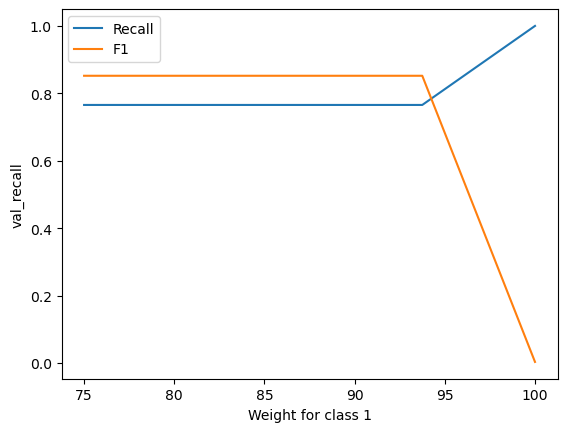

In [40]:
#new
#Ploting f1 score for different weights
cw_results_df = pd.DataFrame(cw_results, 
                             columns=["0_w", 
                                      "1_w", 
                                      "train_f1", "train_recall",
                                      "val_f1", "val_recall"])
sns.lineplot(data=cw_results_df, x="1_w", y="val_recall", label="Recall")
sns.lineplot(data=cw_results_df, x="1_w", y="val_f1", label="F1")
plt.xlabel('Weight for class 1')

In [38]:
cw_results

[(0.0, 100.0, 0.00345118904247479, 1.0, 0.0034511580252905173, 1.0),
 (25.0, 75.0, 1.0, 1.0, 0.8521739130434782, 0.765625),
 (50.0, 50.0, 1.0, 1.0, 0.8421052631578947, 0.75),
 (75.0, 25.0, 1.0, 1.0, 0.8347826086956521, 0.75),
 (100.0, 0.0, 0.0, 0.0, 0.0, 0.0)]

Text(0.5, 0, 'Weight for class 1')

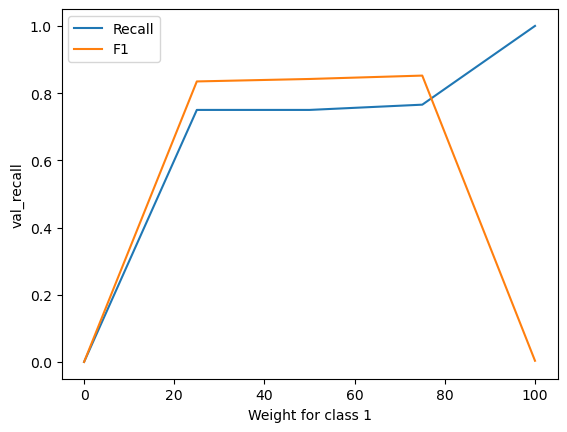

In [37]:
#Ploting f1 score for different weights
cw_results_df = pd.DataFrame(cw_results, 
                             columns=["0_w", 
                                      "1_w", 
                                      "train_f1", "train_recall",
                                      "val_f1", "val_recall"])
sns.lineplot(data=cw_results_df, x="1_w", y="val_recall", label="Recall")
sns.lineplot(data=cw_results_df, x="1_w", y="val_f1", label="F1")
plt.xlabel('Weight for class 1')

## Random Undersampling

In [ ]:
seed = 39 # follows random state of model.py

In [ ]:
us_model = Pipeline(
    [("clf", FraudDetector())]
)

In [ ]:
# Let's create resampled X_train samples

# Note that we're using X_train -- the one where we don't have the validation set anymore
rus = RandomUnderSampler(random_state=seed)
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)

In [ ]:
# Model Training
us_model.fit(X_train_us, y_train_us)

# Check on the validation set
us_preds = us_model.predict(X_val)

In [ ]:
print("Random Under Sampling Performance on the Validation Set:\n")
print(f"Training F1 Score: {f1_score(y_val, us_preds):.4f}")
print(classification_report(y_val, us_preds))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, us_preds)))

In [ ]:
print(f"Class instance count before SMOTE: {Counter(y_train)}")
print(f"Class instance count after SMOTE: {Counter(y_train_us)}")
print("-" * 65)

# PLOTTING
datasets = [X_train, X_train_us]

## Plotting proper
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
names = ["Original", "SMOTE"]
targets = [y_train, y_train_us]
for i, ax in enumerate(axes):
    curr_data = datasets[i]
    sns.scatterplot(x=curr_data.iloc[:, 0],y=curr_data.iloc[:, 1], ax=ax, hue=targets[i])
    ax.set_title(names[i])
plt.tight_layout()

In [ ]:
#used to compute the bank specific rates
us_results = confusion_matrix(y_val, us_preds)
print("Fraud Capture Rate?")
print(us_results[1][1]/
      (us_results[1][0]+us_results[1][1]))

## Random Oversampling

In [ ]:
os_model = Pipeline(
    [("clf", FraudDetector())]
)

In [ ]:
# Let's create resampled X_train samples

# Note that we're using X_train -- the one where we don't have the validation set anymore
ros = RandomOverSampler(random_state=seed)
X_train_os, y_train_os = ros.fit_resample(X_train, y_train)

In [ ]:
# Model Training
os_model.fit(X_train_os, y_train_os)

# Check on the validation set
os_preds = os_model.predict(X_val)

In [ ]:
print("Random Over Sampling Performance on the Validation Set:\n")
print(f"Training F1 Score: {f1_score(y_val, os_preds):.4f}")
print(classification_report(y_val, os_preds))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, os_preds)))

very minimal improvement (0.75 -> 0.77)

In [ ]:
print(f"Class instance count before SMOTE: {Counter(y_train)}")
print(f"Class instance count after SMOTE: {Counter(y_train_os)}")
print("-" * 65)

# PLOTTING
datasets = [X_train, X_train_os]

## Plotting proper
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
names = ["Original", "SMOTE"]
targets = [y_train, y_train_os]
for i, ax in enumerate(axes):
    curr_data = datasets[i]
    sns.scatterplot(x=curr_data.iloc[:, 0],y=curr_data.iloc[:, 1], ax=ax, hue=targets[i])
    ax.set_title(names[i])
plt.tight_layout()

In [ ]:
#used to compute the bank specific rates
os_results = confusion_matrix(y_val, os_preds)
print("Fraud Capture Rate?")
print(os_results[1][1]/
      (os_results[1][0]+os_results[1][1]))

## SMOTE Untuned

In [ ]:
smote_model = Pipeline(
    [("clf", FraudDetector())]
)

In [ ]:
# Let's create resampled X_train samples

smote = SMOTE(random_state=seed, k_neighbors=8)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
smote_model.fit(X_train_smote, y_train_smote)
smote_preds = smote_model.predict(X_val)

In [ ]:
print("SMOTE Sampling Performance on the Validation Set:\n")
print(classification_report(y_val, smote_preds))
print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, smote_preds)))

In [ ]:
print(f"Class instance count before SMOTE: {Counter(y_train)}")
print(f"Class instance count after SMOTE: {Counter(y_train_smote)}")
print("-" * 65)

# PLOTTING
datasets = [X_train, X_train_smote]

## Plotting proper
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
names = ["Original", "SMOTE"]
targets = [y_train, y_train_smote]
for i, ax in enumerate(axes):
    curr_data = datasets[i]
    sns.scatterplot(x=curr_data.iloc[:, 0],y=curr_data.iloc[:, 1], ax=ax, hue=targets[i])
    ax.set_title(names[i])
plt.tight_layout()

In [ ]:
#used to compute the bank specific rates
smote_results = confusion_matrix(y_val, smote_preds)
print("Fraud Capture Rate?")
print(smote_results[1][1]/
      (smote_results[1][0]+smote_results[1][1]))

## SMOTE Tuned

In [ ]:
smote_tuning_model = imb_pipeline(
    [
        ("smote", SMOTE(random_state=seed)),
        ("clf", FraudDetector())
    ]
)

In [ ]:
smote_params = {"smote__k_neighbors": range(1, 11)}

# Model training
smote_skf = StratifiedKFold(n_splits=5, random_state=39, shuffle=True)

smote_rcv = RandomizedSearchCV(smote_tuning_model, smote_params, random_state=seed, scoring='f1', cv=smote_skf)
smote_search = smote_rcv.fit(X_train, y_train)

best_smote_params = smote_search.best_params_
print(best_smote_params)

In [ ]:
cv_scores = { key.split("_")[0] : value for key, value in smote_search.cv_results_.items() if "split" in key }
train_scores = pd.DataFrame(cv_scores)
train_scores["k"] = range(1, 11)

flat_df = train_scores.melt(id_vars="k")

plt.figure(figsize=(12, 5))
sns.lineplot(data=flat_df, x="k", y="value")
#plt.axvline(3, linestyle="--", color="red", alpha=1)
plt.ylabel("F1 Score")
plt.xlabel("k_neighbors")
plt.show()

In [ ]:
plt.figure(figsize=(12, 5))
sns.violinplot(data=flat_df, x="k", y="value", inner="point")
plt.ylabel("F1 Score")
plt.xlabel("k_neighbors")
plt.title("CV F1 Score Distribution per k")
plt.show()

In [ ]:
print(cv_scores)

In [ ]:
print(flat_df)

note that detection rate in case is catch rate in industry, which is recall
https://www.infosysbpm.com/blogs/bpm-analytics/fraud-management-kpis.html 
https://sqnbankingsystems.com/blog/2024-guide-to-fraud-analytics-for-bankers/ 

"Fraud capture rate (percentage of fraudulent transactions successfully identified)"
https://www.galileo-ft.com/blog/ai-fraud-controls-customer-era/ 
https://www.sciencedirect.com/science/article/pii/S2666827022000111

so TP_1 = number of fraud transaction identified as fraud
FN_1 = number of fraud transactions predicted as safe

$$FCR = \frac{TP_1}{TP_1+FN_1} = Recall (also?)$$

but chabby also notes that documents can differ per organization

"fraud capture rates improved by 3%, from 40% (with false positive rate 11:1) in 2022 to 43% (with false positive rate 11:1) in 2023" 
how is this possible?

https://www.socure.com/blog/outperform-fraud-detection-improvements 

other papers suggest using metrics on FP and/or FN rates but idk if we are allowed that for this project

https://www.sciencedirect.com/science/article/pii/S2666827022000111
                                                                                https://d1.awsstatic.com/fraud-detector/afd-technical-guide-detecting-new-account-fraud.pdf

how much money the model could save CreditByte c/o migs and amiel maybe